**kV Field Size - Gradient Method**

The following script uses gradient-based edge detection to find the kV Field size. 

I will first clone the data from Github, followed by applying a Gaussian blur to reduce the noise in the image.

(Authors: Alex Grimwood & John Wong)

In [11]:
###################################
# import all the modules you need #
###################################
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os
!rm -r kV_Field_Analysis
!git clone --branch demo https://github.com/UCLHp/kV_Field_Analysis.git

Cloning into 'kV_Field_Analysis'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 72 (delta 28), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (72/72), done.


In [17]:
#####################
# Inputing the data #
#####################
path = '/content/kV_Field_Analysis/*.bmp'

img = [] # raw image array
name = [] # labels for the image

# find all files and load them into img using a for loop
for fname in glob.glob(path):
    # labeling files
    path,f = os.path.split(fname)
    name.append(f)
    # reading files
    img.append(cv2.imread(fname, cv2.IMREAD_GRAYSCALE))
# convert the list into an array
img = np.array(img, dtype='float32')

#################
# Gaussian blur #
#################
# Applying Gaussian blur to all image
blur_img = [] # create an empty list
for i in range(img.shape[0]): # lopo through images
    blur_img.append(cv2.GaussianBlur(img[i,:,:],(21,21),0)) # blur with a 21x21 pixel kernel
# convert the list into an array
blur_img = np.array(blur_img)

This method will attempt to find the kV Field size by detecting field edges from the pixel intensity gradient.

The function below will generate gradient images. 

In [18]:
def gradient_images(blur_img, kernel_size):
    """ 
    This function will take a grayscale image and output arrays of the pixel
    intensity first and second derivatives.

    input:
        blur_img:     input image, where image must be 2D numpy array

        kernel_size:  size of kernel used to calculate image gradient


    output: 
        dx:         horizontal gradient array

        dy:         vertical gradient array

        grad_img:   magnitude gradient array

        ddx:        horizontal second derivative array (gradient of gradient)

        ddy:        vertical second derivative arrayd 

        dgrad_img:  magnitude of second derivative array               
    """

    step = kernel_size//2
    # array subtraction for first differential
    dy = np.zeros(blur_img.shape)
    dy[:,step:-step,:] = blur_img[:,kernel_size:,:] - blur_img[:,:-kernel_size,:]
    dx = np.zeros(blur_img.shape)
    dx[:,:,step:-step] = blur_img[:,:,kernel_size:] - blur_img[:,:,:-kernel_size]
    grad_img = np.sqrt(dx**2+dy**2) # calculate magnitude of gradients
    
    # array subtraction for second differential
    ddy = np.zeros(blur_img.shape)
    ddy[:,step:-step,:] = dy[:,kernel_size:,:] - dy[:,:-kernel_size,:]
    ddx = np.zeros(blur_img.shape)
    ddx[:,:,step:-step] = dx[:,:,kernel_size:] - dx[:,:,:-kernel_size]
    dgrad_img = np.sqrt(ddx**2+ddy**2) # calculate magnitude of gradients

    return dx, dy, grad_img, ddx, ddy, dgrad_img

The code below was finds the isocentre of the kV field from 4 BBs placed 10 cm from the laser isocentre 

In [19]:
# average all images together and then extract profiles across small BBs 
avg_img = np.mean(img,0)
h_profile = np.mean(avg_img[603-4:603+4,:],0)
v_profile = np.mean(avg_img[:,799-4:799+4],1)

# manually find minima indices
a_idx = np.argmin(h_profile[400:500])+400
b_idx = np.argmin(h_profile[1100:1200])+1100
g_idx = np.argmin(v_profile[220:300])+220
t_idx = np.argmin(v_profile[900:995])+900

# calculate pixel size in mm
px_x = 200/(b_idx-a_idx)
px_y = 200/(t_idx-g_idx)
p2mm = (px_x+px_y)/2

# calculate laser centre
laser_isopx = np.array((a_idx + ((b_idx-a_idx)/2), g_idx + ((t_idx-g_idx)/2)))
laser_x, laser_y = laser_isopx

The code below loops through all images, calculates their 2nd derivative and uses this information to estimate the mean location of all four kV field edges.  
  
Median intensity profiles of the original image are plotted with marked edge locations.

In [20]:
# median intensity profile datasets
x_mip = []
y_mip = []

# field edge location datasets
a_pk = []
b_pk = []
g_pk = []
t_pk = []

# Loop through all kV images
kernel_size = 40
for i in range(img.shape[0]):

  # calculate 2nd derivative gradient images
  _, _, _, ddx, ddy, _ = gradient_images(blur_img, kernel_size)

  # manually subtract unwanted image features, i.e. BBs and noisy border
  # null BB rows & cols
  ddx[:,550:670,:] = 0#np.nan # horizontal null
  ddx[:,:,750:870] = 0#np.nan # vertical null
  ddy[:,550:670,:] = 0#np.nan # horizontal null
  ddy[:,:,750:870] = 0#np.nan # vertical null
  # null FoV rows & cols
  ddx[:,:,:50] = 0#np.nan # horizontal null
  ddx[:,:,-51:] = 0#np.nan # vertical null
  ddx[:,:50,:] = 0#np.nan # horizontal null
  ddx[:,-51:,:] = 0#np.nan # vertical null
  ddy[:,:,:50] = 0#np.nan # horizontal null
  ddy[:,:,-51:] = 0#np.nan # vertical null
  ddy[:,:50,:] = 0#np.nan # horizontal null
  ddy[:,-51:,:] = 0#np.nan # vertical null

  # locate the minima in each quadrant
  x_profile = np.median(ddx[i,...],axis=0)
  y_profile = np.median(ddy[i,...],axis=-1)
  a_pk.append(np.argmin(x_profile[:801]))
  b_pk.append(np.argmin(x_profile[800:])+800)
  g_pk.append(np.argmin(y_profile[:601]))
  t_pk.append(np.argmin(y_profile[600:])+600)


Display the kV image(s) with overlaid field edges and and calculate field sizes in mm.

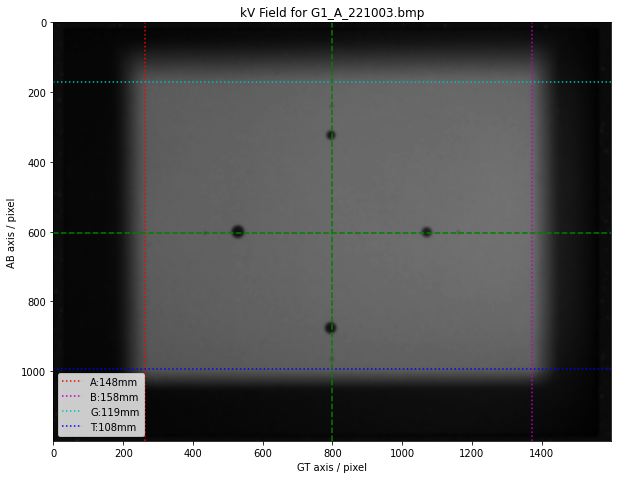


Field Sizes:

A-side = 148 mm
B-side = 158 mm
G-side = 119 mm
T-side = 108 mm


In [28]:
# plot field edge locations on kV images
for i in range(img.shape[0]):
  # Calculating edge to isocentre size (mm)
  A = (laser_x - a_pk[i]) * p2mm
  B = (b_pk[i] - laser_x) * p2mm
  G = (laser_y - g_pk[i]) * p2mm
  T = (t_pk[i] - laser_y) * p2mm

  # plot image
  plt.figure(figsize=(10, 10))   
  plt.imshow(blur_img[i,...], cmap='gray', vmin=0, vmax=75)
  # plot field edges
  plt.plot([a_pk[i],a_pk[i]], [0,1199], color='r', linestyle='dotted', label='A:{:.0f}mm'.format(A))
  plt.plot([b_pk[i],b_pk[i]], [0,1199], color='m', linestyle='dotted', label='B:{:.0f}mm'.format(B))
  plt.plot([0,1599], [g_pk[i],g_pk[i]], color='c', linestyle='dotted', label='G:{:.0f}mm'.format(G))
  plt.plot([0,1599], [t_pk[i],t_pk[i]], color='b', linestyle='dotted', label='T:{:.0f}mm'.format(T))
  # plot laser isocentre
  plt.axvline(x = laser_x, color='g', linestyle='--')
  plt.axhline(y = laser_y, color='g', linestyle='--')
  # graph setting
  plt.title("kV Field for {}".format(name[i]))
  plt.xlabel("GT axis / pixel")
  plt.ylabel("AB axis / pixel")
  plt.legend(loc='lower right')
  plt.legend()
  plt.show()

  # Print field sizes
  print("\nField Sizes:\n")
  print(f"A-side = {A:.0f} mm")
  print(f"B-side = {B:.0f} mm")
  print(f"G-side = {G:.0f} mm")
  print(f"T-side = {T:.0f} mm")